## Contents:
* [A Generic Data Science Case Study](#turo)
* [Questions](#questions)
* [Analysis](#analysis)
* [Modeling](#modeling)
* [Recommendation Function](#recommendations)
* [Measuring business impact](#business)

<a id="turo"></a>

# A Generic Data Science Case Study

When listing a car, a host has the opportunity to set its daily price. In this process, A Generic Company recommends a price (which the host may accept or ignore) that is designed to optimize the host’s revenue, given various properties of the listing.

The accompanying file `vehicles_booking_history.csv` contains a sampling of historical data. The dictionary is:
 * `vehicle_id` - vehicle's unique ID
 * `date` - calendar date
 * `tmv` - true market value of vehicle
 * `category_aggregate` - vehicle category group
 * `demand_supply_ratio` - demand (count of web and app sessions) over supply (count of live listings) in the vehicle's local market city on a given day
 * `price` - vehicle's listed price as of the given date
 * `is_booked` - 1 or 0, depending on if the listing got booked (on this date, at this price, etc)

1. Based on this historical data, produce a production-level function that accepts properties of a listing and returns a daily price that is designed to improve/optimize revenue. 

2. Assuming your function is deployed in production, describe metrics and methods to gauge the success of your recommendations. 

We’re looking for:
* your _approach_ to analysis/modeling---don't chase perfect models, especially given the small amount of data, but be prepared to discuss how you would pursue a good model if there were sufficient data;
* organized and intuitive production-level code for the recommendation function itself, as though it were part of a REST API implementation;
* thoughtful consideration of how to measure business impact, acknowledging any nuances.


<a id="questions"></a>
## 1. Based on this historical data, produce a production-level function that accepts properties of a listing and returns a daily price that is designed to improve/optimize revenue.


__Questions__


After thinking about this problem for some time and looking at the data, the following questions came up:

__1. What does is mean to optimize a host's revenue?__

I don't think the goal would be only to optimize host revenue, as there would likely be some cost function on the Generic Company's side to calculate profit. Additionally, on the demand side, from those looking for a host vehicle, how are they impacted? Does optimize/improve revenue mean maximizing a host's monthly revenue? Which brings up the following question:

__2. What else should we look to optimize?__

In the paper _Reinforcement Learning for Fair Dynamic Pricing_, the authors suggest that there is a trade-off between revenue and fairness. Specifically in this case they state:

> Equality is a critical aspect of
dynamic pricing as it influences customers’ perceptions of
fairness [6]–[11]. As long as perceptions of fairness are used
by people as a heuristic for trust, inequality may lead to a
destruction of that trust. For instance, large price differences
between groups of customers, or a disagreement between
the distribution of cost and profit are known to affect the
relationship between customers and sellers [12]. Should this
relationship be damaged, it could eventually generate substantial financial losses for a company in the medium- and longterm [13]

__3. What would we need for a "good" model?__

I think there are a few things missing from this dataset that we would ideally want if we were to create a good model, these would be:

__a.__ Location data. I think we would want to model demand by location as well as over time.

__b.__ Host context. The discussion fairness brought up by the authors of _Reinforcement Learning for Fair Dynamic Pricing_ to me suggests that host characteristics would influence their perception of our price suggestions. For example, perhaps someone who depends on Turo as a source of income may be more sensitive to price suggestions, for them their goal is maximize the number of time of their vehicle is used, resulting on lower average revenue, but more consistent cash flow. Host context may include demograhic and income data or similar data aggregated by location, e.g. average income in the zipcode the host lives. 

__c.__ Vehicle context. This would include make, model, and options.

__4. What contraints do we have?__

This question follows from our initial question of what it means to optimize a host's revenue, and this perhaps extends from the business model. An example of a contraint would be: Is there a limit to which we could suggest a lower price? 

__5. Alternative ways to price?__

I would be curious to see what pricing from the customer side looks like. For example, _when_ a customer books a car, how far ahead do they book and what do bookings look like as they get closer to the day of actually picking up a car? Forcasting demand perhaps would allow us to automatically adjust prices for hosts (if they chose to allow us to). 

<a id="analysis"></a>

## Analysis


(Import the data and do analysis/modeling/math starting here.)

__Data Issues__

I can't tell if ```price``` is A Generic Company's suggested price or the price set by the host.

Gaps in time series.


__Analysis Steps__

1. Look at time trends

Since we are dealing with demand, supply, and prices I would be interested to see what happens over time both in aggregate and across different variables (specific vehicles and class of vehicle).

2. Look at group level statistics

3. Look at specific examples

4. Look at the impact of price of likelihood of being booked



In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

from scipy.stats import poisson
from utils.utils import Processing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.display import Image

from collections import Counter
sns.set(style="dark")

%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/maitsukiyama/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poisson']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
df = pd.read_csv('vehicles_booking_history.csv')

In [25]:
df.shape

(1890, 7)

## Process data

In [26]:
df = Processing.clean(df)

In [27]:
df.dtypes

vehicle_id                      int64
date                   datetime64[ns]
is_booked                       int64
tmv                             int64
category_grouped               object
demand_supply_ratio           float64
price                         float64
day                             int64
week                            int64
month                           int64
log_price                     float64
log_tmv                       float64
host_revenue                  float64
day_bookings                    int64
dtype: object

In [28]:
df['demand_supply_ratio'].describe()

count    1890.000000
mean        6.043046
std         3.951393
min         0.463101
25%         3.002744
50%         5.694339
75%         8.431289
max        23.333333
Name: demand_supply_ratio, dtype: float64

In [29]:
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,day,week,month,log_price,log_tmv,host_revenue,day_bookings
0,174075,2018-02-12,1,5669,midsize,5.269737,30.0,0,7,2,3.401197,8.642768,30.0,3
1,174075,2018-02-13,0,5669,midsize,4.934747,30.0,1,7,2,3.401197,8.642768,0.0,1
2,174075,2018-02-14,0,5669,midsize,5.443163,30.0,2,7,2,3.401197,8.642768,0.0,0
3,174075,2018-02-17,1,5669,midsize,7.376040,30.0,5,7,2,3.401197,8.642768,30.0,1
4,174075,2018-02-21,0,5669,midsize,5.173203,30.0,2,8,2,3.401197,8.642768,0.0,0


## Bookings over time

> It seems that bookings peak during the summer, July and August, as well as in January. So perhaps there are some seasonal trends. 

Text(0.5, 0, 'Date')

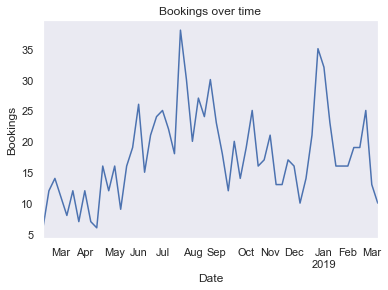

In [30]:
df.set_index('date').resample('W').sum()['is_booked'].plot()
plt.title('Bookings over time')
plt.ylabel('Bookings')
plt.xlabel('Date')

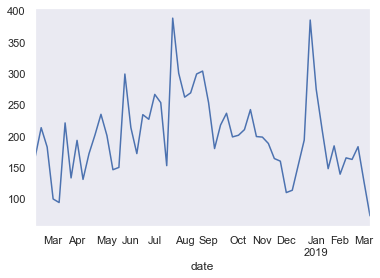

In [8]:
df.set_index('date').resample('W').sum()['demand_supply_ratio'].plot()

## Look at bookings over time for different vehicle categories

> While the time trend for SUVs seems to follow the aggregate trend, the trend for compat cars does not.

Perhaps there are multiple demand curves.

In [9]:
Counter(df.category_grouped).most_common()[:10]

[('suv', 687),
 ('midsize', 634),
 ('compact', 421),
 ('upscale', 80),
 ('van', 68)]

## SUV

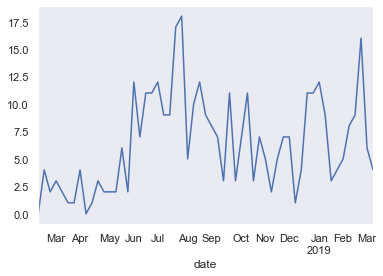

In [10]:
df.query('category_grouped == "suv"').set_index('date').resample('W').sum()['is_booked'].plot()

## Compact

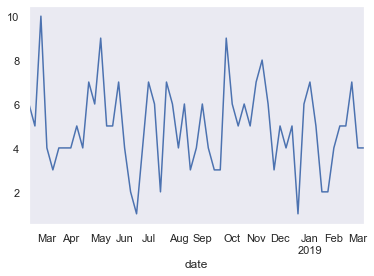

In [11]:
df.query('category_grouped == "compact"').set_index('date').resample('W').sum()['is_booked'].plot()

## Midsize

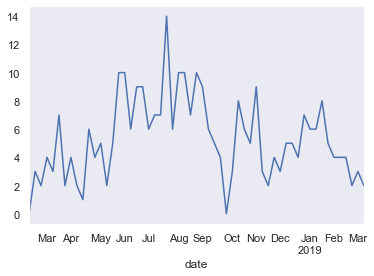

In [12]:
df.query('category_grouped == "midsize"').set_index('date').resample('W').sum()['is_booked'].plot()

## Average price over time

> Average prices seem to follow demand (bookings). Though it seems like there is some lag.

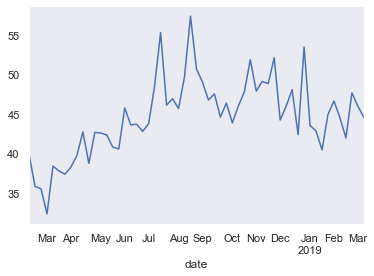

In [13]:
df.set_index('date').resample('W').mean()['price'].plot()

## Looking at group statistics

1. Average price by vehicle category

2. Average demand supply ratio by vehicle category

3. Average booking rate by vehicle category



In [14]:
df.groupby('category_grouped').mean()['price']

category_grouped
compact    34.995249
midsize    36.014196
suv        57.909753
upscale    32.000000
van        86.617647
Name: price, dtype: float64

In [15]:
df.groupby('category_grouped').mean()['demand_supply_ratio']

category_grouped
compact    8.378004
midsize    5.526643
suv        5.327081
upscale    2.720264
van        7.544108
Name: demand_supply_ratio, dtype: float64

In [16]:
df.groupby('category_grouped').mean()['is_booked']

category_grouped
compact    0.667458
midsize    0.477918
suv        0.532751
upscale    0.450000
van        0.441176
Name: is_booked, dtype: float64

## What is the relationship between price and bookings?

In [17]:
demand = df.groupby('price').sum()['is_booked'].reset_index()

In [18]:
demand['price'].describe()

count     84.000000
mean      61.666667
std       30.516965
min       10.000000
25%       36.750000
50%       57.500000
75%       83.500000
max      134.000000
Name: price, dtype: float64

In [19]:
demand['is_booked'].describe()

count     84.000000
mean      12.095238
std       19.997963
min        0.000000
25%        1.000000
50%        4.000000
75%       12.000000
max      107.000000
Name: is_booked, dtype: float64

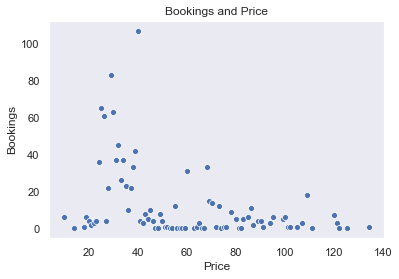

In [20]:
sns.scatterplot(x="price", y="is_booked",
                data=demand)
plt.title('Bookings and Price')
plt.ylabel('Bookings')
plt.xlabel('Price')
plt.savefig('images/demand_and_price.png')

## What are the most common vehicles?

most common: 300476

In [21]:
Counter(df.vehicle_id).most_common()[:10]

[(300476, 123),
 (238765, 115),
 (302205, 114),
 (233590, 112),
 (333483, 111),
 (298081, 108),
 (406331, 106),
 (388325, 103),
 (326416, 97),
 (428355, 90)]

## What is the total revenue by vehicle?

> 0 revenue: Vehicle id 234096 
    
> Most revenue: Vehicle id 406331

I want to look at these two specific vehicles.

__Findings__


1. 234096 which had zero bookings was midsize vehicle

2. 406331 which had the most revenue was a suv

The average demand supply ratio between these two vehicles did not differ that much. However difference in variance was significantly large, with corresponding variance in prices for 406331. 

In [22]:
df.groupby('vehicle_id').sum()['host_revenue'].sort_values()

vehicle_id
234096       0.0
333483      24.0
456223      42.0
535905     531.0
487863     603.0
289235     660.0
508104     696.0
388325     780.0
304273     887.0
497131    1010.0
416371    1055.0
448045    1199.0
466729    1466.0
174075    1558.0
233590    1576.0
326416    1606.0
391074    2036.0
426430    2230.0
300476    2243.0
298081    2507.0
302205    3062.0
238765    3709.0
405192    3744.0
428355    4969.0
406331    5378.0
Name: host_revenue, dtype: float64

In [23]:
df.query('vehicle_id == 234096')['price'].describe()

count    42.000000
mean     58.000000
std       2.695977
min      48.000000
25%      58.000000
50%      59.000000
75%      59.000000
max      60.000000
Name: price, dtype: float64

In [24]:
df.query('vehicle_id == 234096')['category_grouped'][:1]

189    midsize
Name: category_grouped, dtype: object

In [25]:
df.query('vehicle_id == 234096')['demand_supply_ratio'].describe()

count    42.000000
mean      8.749823
std       1.949365
min       5.161290
25%       7.144285
50%       8.551348
75%      10.608813
max      12.331512
Name: demand_supply_ratio, dtype: float64

In [26]:
df.query('vehicle_id == 406331')['price'].describe()

count    106.000000
mean      93.207547
std       15.727269
min       64.000000
25%       83.000000
50%       94.500000
75%      100.000000
max      134.000000
Name: price, dtype: float64

In [27]:
df.query('vehicle_id == 406331')['category_grouped'][:1]

1275    suv
Name: category_grouped, dtype: object

In [28]:
df.query('vehicle_id == 406331')['demand_supply_ratio'].describe()

count    106.000000
mean       8.949119
std        3.746450
min        3.972383
25%        6.188888
50%        7.607939
75%       12.317943
max       18.467314
Name: demand_supply_ratio, dtype: float64

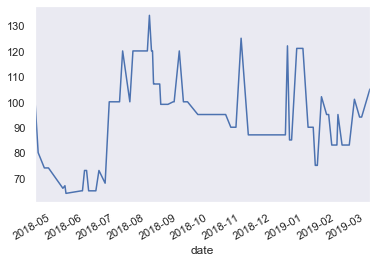

In [29]:
df.query('vehicle_id == 406331').set_index('date')['price'].plot()

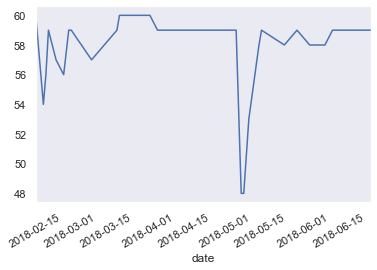

In [30]:
df.query('vehicle_id == 234096').set_index('date')['price'].plot()

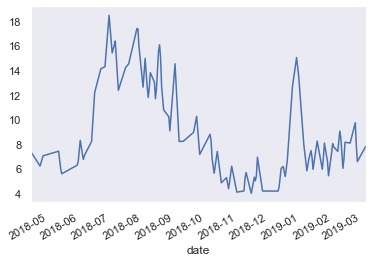

In [31]:
df.query('vehicle_id == 406331').set_index('date')['demand_supply_ratio'].plot()

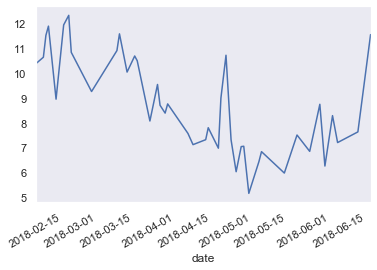

In [32]:
df.query('vehicle_id == 234096').set_index('date')['demand_supply_ratio'].plot()

<a id="modeling"></a>

## Modeling


__Questions__

The big question here is the ```is_booked``` column. This column seems to represent what happens after a price is set; therefore would not be available at the time of prediction. However it begs the question as to how we would validate whether our suggested price is optimizing host revenue when we look to train a model offline. 


### __Approach__


I am not going to go chase perfect models. However there is perhaps one straightforward way to approach this problem: maximize revenue for host vehicles:

1. Predict ```is_booked```. This output can be used to predict the expected value of revenue from a host's vehicle.

Another approach is to model demand. However given the data this approach would be difficult. This project states:

> demand (count of web and app sessions) over supply (count of live listings) in the vehicle's local market city on a given day

However this may not really reflect demand.

A data scientist at the Generic Company had the very strong opinion that this problem should be modeled as follows:

1. Create a model to predict ```is_booked```.
2. Use the probability of ```is_booked``` as the expected value.
3. Maximize expected value.

Therefore we will try to attempt this approach here. I took my cue from the following paper and paper adaptation:

[_Dynamic room pricing model for hotel revenue management systems_](https://www.sciencedirect.com/science/article/pii/S1110866511000375#s0030)

[_Dynamically Pricing Hotel Rooms for Maximum Revenue_](https://www.datascience.com/resources/notebooks/dynamically-pricing-hotel-rooms-with-data-science)

In [200]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from utils.models import Model, Metrics, Scoring, Train, Pricing
from utils.utils import Processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
df = pd.read_csv('vehicles_booking_history.csv')

## Predict ```is_booked``` 

First we build a model to predict ```is_booked```. I am not concerned with optimizing this model for this exercise, as this is more to show how to approach this problem.


According to [_Dynamic room pricing model for hotel revenue management systems_](https://www.sciencedirect.com/science/article/pii/S1110866511000375#s0030)

[_Dynamically Pricing Hotel Rooms for Maximum Revenue_](https://www.datascience.com/resources/notebooks/dynamically-pricing-hotel-rooms-with-data-science)

We build a function for demand price elasticity, where elasticity of demand is set at -2.0. 

```python
    def price_elasticity(self, price, nominal_demand):
        return nominal_demand * ( price / self.nominal_price ) ** (self.elasticity)
```

We use demand and demand elasticity for this constrained optimization problem given a supply of vehicles. 

The main assumption here that we know the supply of similar vehicles.

In [202]:
Model.baseline_classifier(df)

Accuracy Score:0.8571428571428571
ROC score: 0.9216909216909217
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        78
           1       0.91      0.84      0.87       111

    accuracy                           0.86       189
   macro avg       0.85      0.86      0.85       189
weighted avg       0.86      0.86      0.86       189

Classification report: None


/Users/maitsukiyama/miniconda3/envs/test/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<a id="recommendations"></a>
## Recommendation function
(Write a function that takes the properties of the listing and returns a price here.)

Full workflow:

1. Load data

2. Train model

3. Load model and pipe for feature transormation

4. Predict price


## API

You can also test this as an API by running from the command line:

```
python api.py
```

And then test it with a payload from another terminal:

```
./local_test.sh
```

## Caveats

I did not create tests (I had scoped this out with a time limit in mind).

In [203]:
df = pd.read_csv('vehicles_booking_history.csv')

__train model__

In [204]:
Train.train_booking_classifier(df)

Accuracy Score:0.8386243386243386
ROC score: 0.9013761467889908
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       160
           1       0.87      0.84      0.86       218

    accuracy                           0.84       378
   macro avg       0.83      0.84      0.84       378
weighted avg       0.84      0.84      0.84       378

Classification report: None


/Users/maitsukiyama/miniconda3/envs/test/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [195]:
model = Scoring.load_model()
pipe = Scoring.load_pipe()

In [197]:
payload = {'date':'2018-11-14',
           'tmv':19525,
           'price': 19,
           'category_grouped':'compact',
           'demand_supply_ratio':4.70207,
           'supply':10}

In [198]:
def predict(payload):
    """
    Args: json
        - For example if this was an API
        
        payload = {'date':'2018-11-14',
                   'tmv':19525,
                   'category_grouped':'compact',
                   'demand_supply_ratio':4.70207,
                   'supply':30}
    
    """
    demand, supply, features = Processing.clean_payload(payload)
    features = pipe.transform(features)
    score = model.predict_proba(features)[:,1]
    pricing_model = Pricing(score[0])
    return pricing_model.predict(demand, supply)
    

In [199]:
predict(payload)

38.0

<a id="business"></a>

## Measuring business impact
(Tell us how you'd gauge the success/business impact of the suggested price.)


I think there are a few moving parts here. First I think ultimately improved profit would be what we want when we try to optimize pricing. However maximizing revenue should be balanced against optimizig revenue for hosts and optimizing fairness for customers. 

If we get increased aggregate utilization of hosts vehicles, that would be success. There are some vehicles in this sample of data which had very low or no utlilization. However, I could also see success being increased per vehicle revenue; which may not result in increased utliization.

__Having written all this, perhaps a simple metric to track is rate of bookings.__

In other words, the effect size of introducing a new pricing suggestion model on booking rate.

__Caveats__

There are a few things I am unsure of:

1. Constraints on supply and price

For example is there some floor price for vehicles?

2. Modeling demand aggregation by location and time

3. How often hosts take our suggestions

This sample of data does not give me a good idea of demand. I guess the question would be: do we know what actual demand looks like? Depending on the answer to that, that will influence how we test our prices. 


Thinking about this, while this sounds simple I think there are a few confounding issues. First, hosts do not have to take our suggestions. Which means you have the following: 

1. Bookings on instances when hosts take our suggestions in the original model.

2. Bookings on instances when hosts do not take our suggestions in the original model.

3. Bookings on instances when hosts take our suggestions in the new model.

4. Bookings on instances when hosts do not take our suggestions in the new model.

While you could serve the treatment to random populations, the hosts have a choice in whether to take the treatment; which may not be random; which brings up the question of external validity.

1. Measuring adoption of out price suggestions

2. Using price suggestions to influence hosts to opt into automated pricing

__Additional Caveats__

I think something that would be difficult to deal with is time trends. For example if we had an experiment that sought to test our current pricing model against a new pricing model, success measured by improvements in bookings. I assume we are not running this single experiment through the entire year; which means what we see at that point in time does not represent what would happen trhoughout the entire year.


This brings me back to the issue of demand. I can imagine two avenues, price learning in which we deploy prices to discover what demand would be and then using that to create models to optimize price.